## Chapter 09 텍스트를 위한 인공 신경망 ▶️한빛 마켓의 댓글을 분석하라!
#### 09-2 순환 신경망으로 IMDB 리뷰 분류하기 ▶️텐서플로 순환 신경망으로 영화 리뷰 분류하기 
--- 
- 먼저 영화리뷰 텍스트들인 imdb를 가져와, 각 리뷰들의 텍스트 길이를 모두 일정하게 만든다. 
- 이때 매개변수를 지정하는데, 매개변수=500이라면 자주 등장하는 500개의 word를 가지고 분석하겠다는 뜻이다. 
- 텍스트를 분석하기 위해서는 단어들을 1) One-hot coding을 통해 0과 1로 바꿔주거나, 2) Embedding을 사용하여 각 단어를 고정된 크기의 실수 벡터로 바꿔주어야 한다. 
- 자연어 처리에서 보통 embedding이 더 좋은 성능을 낸다. 
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras

# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#### 1. imDB 불러오기 
- imdb는 총 50000개의 영화리뷰 텍스트와, 텍스트의 감정상태(0:Negative, 1:Positive)를 담고 있다. 
- train/test dataset 각 25000개이며, 각 단어(tokken)들은 고유한 정수값으로 매핑되어 있다. 
- ex. "He follows the cat. He loves the cat" --> 10 11 12 13 10 14 12 13 

In [2]:
## num_words = 500 : 전체 텍스트에서 자주 등장하는 500개의 단어(tokken)을 어휘사전으로써 사용하겠다는 뜻 
## RNN의 채널차원 갯수로 사용된다. 
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.imdb.load_data(num_words = 500)
'''
아래와 같이 해도 동일함 
from tensorflow.keras.datasets import imdb 
(train_input, train_target), (test_input, test_target) = \
    imdb.load_data(num_words = 500)
'''

print('1.train input 형태 : ', train_input.shape)
print('2.train target 형태 : ', train_target.shape)
print('3.test input 형태 : ', test_input.shape)
print('4.test target 형태 : ', test_target.shape)

1.train input 형태 :  (25000,)
2.train target 형태 :  (25000,)
3.test input 형태 :  (25000,)
4.test target 형태 :  (25000,)


In [3]:
print('첫번째 리뷰의 길이 = ', len(train_input[0]))
print('두번째 리뷰의 길이 = ', len(train_input[1]))

첫번째 리뷰의 길이 =  218
두번째 리뷰의 길이 =  189


In [4]:
## 첫번째 리뷰를 실제 출력해보기 
## 단어(tokken)들이 정수로 매핑되어 있다. (*참고: 정수매핑시 보통 0은 패팅, 1은 문장의 시작, 2는 어휘사전에 없는 단어에 매팽시킨다.)
print( train_input[0] )

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [5]:
## target 데이터는 0: negative, 1:positive로 매핑되어 있다. 
train_target[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [6]:
## cf. imdb.get_word_index()에 각 단어와 맵핑되는 정수가 저장되어져 있음. 
## 주의할 점은 imdb.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑되는 정수임(IMDB 리뷰 데이터셋에서 정한 규칙) 
## index_to_word에 인덱스를 집어넣으면 전처리 전에 어떤 단어였는지 확인할 수 있음. 
## 0, 1, 2, 3은 특별 토큰으로 취급. 그래서 정수 4부터가 실제 IMDB 리뷰 데이터셋에서 빈도수가 가장 높은 실제 영단어임 
## 아래는 정수로 매핑된 데이터를 인덱스와 매칭하여 실제 텍스트로 변환/확인하는 방법임 
from tensorflow.keras.datasets import imdb 

word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
    
print('빈도수 상위 1등 단어 : {}', index_to_word[4])
print('빈도수 상위 100등 단어 : {}', index_to_word[100])

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):index_to_word[index] = token

print(' '.join([index_to_word[index] for index in train_input[0]]))

빈도수 상위 1등 단어 : {} the
빈도수 상위 100등 단어 : {} could
<sos> this film was just <unk> <unk> <unk> <unk> story direction <unk> really <unk> the part they played and you could just <unk> being there <unk> <unk> is an amazing actor and now the same being director <unk> father came from the same <unk> <unk> as <unk> so i loved the fact there was a real <unk> with this film the <unk> <unk> throughout the film were great it was just <unk> so much that i <unk> the film as <unk> as it was <unk> for <unk> and would recommend it to everyone to watch and the <unk> <unk> was amazing really <unk> at the end it was so <unk> and you know what they say if you <unk> at a film it must have been good and this definitely was also <unk> to the two little <unk> that played the <unk> of <unk> and <unk> they were just <unk> children are often left out of the <unk> <unk> i think because the stars that play them all <unk> up are such a big <unk> for the whole film but these children are amazing and should be <unk> for

In [7]:
## train set의 20%를 검증용 데이터셋으로 분리 
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state = 42 )

print( train_input.shape )
print( val_input.shape )
print( train_target.shape )
print( val_target.shape )

(20000,)
(5000,)
(20000,)
(5000,)


--- 
#### 2. padding을 통해 모든 리뷰들의 길이를 일정하게 만들기 
- 몇글자 안되는 짧은 리뷰, 매우 긴 장문의 리뷰 등등 --> 정해진 길이를 기준으로 길면 잘라내고, 모자라면 0으로 채운다. 

- 전체 리뷰의 갯수는 =  (20000,)
- 리뷰길이의 평균은 =  239.00925
- 리뷰길이의 표준편차는 =  176.67367592382715
- 리뷰길이의 최소값은 =  11
- 리뷰길이의 최대값은 =  1854


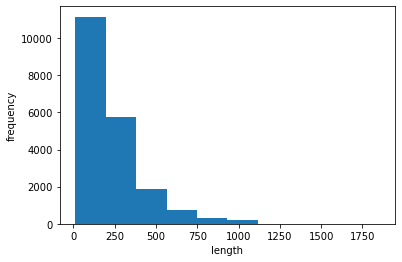

In [8]:
## 리뷰의 길이들이 어떤지 살펴보기 
lengths = [len(x) for x in train_input]

print('- 전체 리뷰의 갯수는 = ' , np.array(lengths).shape ) 
print('- 리뷰길이의 평균은 = ' , np.mean(lengths) )
print('- 리뷰길이의 표준편차는 = ' , np.std(lengths) )
print('- 리뷰길이의 최소값은 = ' , np.min(lengths) )
print('- 리뷰길이의 최대값은 = ' , np.max(lengths) )

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

- 대부분의 리뷰들은 길이가 300개 이하이나, 일부 매우 긴 것들도 존재함 
- 분석을 위해 최대 길이를 통일시켜야 할 필요가 있음 

----
#### 2. pad_sequence() 사용하여 길이 맞추기

In [9]:
## 20000개의 데이터(리뷰)를 최대길이 100으로 맞춰준다. 
## pad_sequences는 기본적으로 데이터의 앞부분을 제거한다. 텍스트의 뒷부분이 더 중요할 것이라는 전제 ... 
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

print(train_seq.shape)
print(val_seq.shape)

(20000, 100)
(5000, 100)


In [10]:
print(len(train_input[0]))
print(train_seq[5])

259
[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 첫번째 텍스트 길이는 100보다 길다, 따라서 앞부분을 잘라내었다. 

In [11]:
print(len(train_input[5]))
print(train_seq[5])

96
[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 이 경우 텍스트 길이가 100보다 짧아 모자란 앞부분이 4개가 0으로 대체되었다. 

--- 
#### 3. RNN 구성 - 1) one-hot encoding 
- 임의로 8개의 뉴련을 배치한다. 출력층은 0과 1을 구분하는 것이므로, 1개의 뉴런이고 함수는 sigmoid 
- 입력값의 형태는 길이가 100개 이고, 라이브러리가 500개이므로 one-hot 인코딩시 500개의 차원이다. 
- 입력값 train_seq의 tokken들이 정수형태인데, 여기서는 정수의 크기가 의미를 가지면 안되기 때문에 one-hot 인코딩이 필요함

In [12]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100, 500)))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


- simple RNN's parameters = (500x8) + (8x8) + 졀편 8 = 4000 + 64 + 8 = 4072 
- dense's parameters = (8x1) + 절편 1 = 8 + 1 = 9 

In [13]:
## one-hot encoding 
train_oh = keras.utils.to_categorical(train_seq) 
val_oh = keras.utils.to_categorical(val_seq) 

print('one-hot 인코딩된 train 데이터셋의 형태 = ', train_oh.shape)
print(train_oh[0][0])

print('one-hot 인코딩된 validation 데이터셋의 형태 = ', val_oh.shape)
print(val_oh[0][0])

one-hot 인코딩된 train 데이터셋의 형태 =  (20000, 100, 500)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

In [14]:
## 원핫 인코딩된 값의 총합은 당연히 1이 되어야 함 
print( np.sum(train_oh[0][0]) )
print( np.sum(val_oh[0][0]) )

1.0
1.0


In [15]:
'''
1) rmsprop의 default learning_rate = 0.001(optimizer = 'rmsprop'), 학습률을 조정하고 싶다면 ... 
   from tensorflow.keras import optimizers
   model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics='accuracy')

2) 문제 종류에 따른 손실함수
 - 이진분류 : binary crossentropy
 - 다중분류 : categorical crossentropy
 - 회귀 : MSE(Mean Squared Error)
 - 시퀀스 : CTC(Connection Temporal Classification)
'''

from tensorflow.keras import optimizers
model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')
chekpoint_callback = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_callback = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model.fit(train_oh, train_target, epochs = 100, batch_size = 64, 
                    validation_data = (val_oh, val_target), 
                    callbacks = [chekpoint_callback, early_stopping_callback] )

Epoch 1/100
313/313 [==============================] - 12s 32ms/step - loss: 0.6968 - accuracy: 0.5075 - val_loss: 0.6923 - val_accuracy: 0.5246
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6879 - accuracy: 0.5418 - val_loss: 0.6828 - val_accuracy: 0.5638
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6777 - accuracy: 0.5800 - val_loss: 0.6763 - val_accuracy: 0.5840
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6702 - accuracy: 0.6000 - val_loss: 0.6692 - val_accuracy: 0.6016
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6619 - accuracy: 0.6209 - val_loss: 0.6608 - val_accuracy: 0.6206
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6513 - accuracy: 0.6407 - val_loss: 0.6516 - val_accuracy: 0.6380
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6395 - accuracy: 0.6613 - val_loss: 0.6388 - val_accuracy

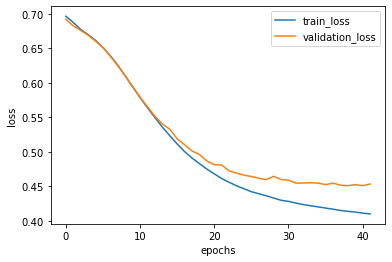

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'validation_loss'])
plt.show()

---
#### 3. RNN 구성 - 2) word embedding
- 원핫코딩은 메모리 낭비가 심하고, 대부분을 차지하는 0으로 채워진 부분들이 계산에서 전혀 역할을 하지 못하는 단점 존재
- 반면 word embedding은 각 단어를 실수값 벡터로 변환하여 계산함으로써, 메모리를 줄이면서 자연어 처리에 보다 좋은 성능을 낸다. 
- 또한 입력값으로 정수 데이터 그대로 받기 때문에, 앞서와 깉은 원핫코딩 변환 작업(train_seq => train_oh)이 불필요 하다. 

In [17]:
## input layer 추가 : 500개의 차원에 대해, 16개의 벡터로써 출력하라, 각 샘플의 길이는 100이다.  
## embedding = 16 : 단어(tokken)을 16개의 실수 벡터로 만들라는 뜻, 적절한 값을 사용자가 지정해줘야 함 
## 앞서와 마찬가지로 hidden layer의 뉴런은 8개를 배치하고, 출력충은 이진분류이므로 뉴런 1개 & 함수는 시그모이드 사용 
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


- 입력층's parameters = 500차원 x 16개 뉴런 = 8000 
- simple_rnn_2's parameters = (입력값 16개 x 뉴런 8개) + (자체순환 8x8) + 절편 8 = 128 + 64 + 8 = 200 
- dense_2's parameters = 입력 8개 x 뉴런 1개 + 절편 1개 = 9 

In [18]:
model2.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = 'accuracy')
chekpoint_callback2 = keras.callbacks.ModelCheckpoint('best-embedding-rnn-model.h5')
early_stopping_callback2 = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

## one-hot 코딩 불필요하므로, train_oh & val_oh 대신 train_seq & val_seq를 그대로 사용 
history2 = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64, 
                    validation_data = (val_seq, val_target), 
                    callbacks = [chekpoint_callback2, early_stopping_callback2] )

Epoch 1/100
313/313 [==============================] - 4s 9ms/step - loss: 0.6849 - accuracy: 0.5494 - val_loss: 0.6596 - val_accuracy: 0.6102
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6227 - accuracy: 0.6683 - val_loss: 0.6018 - val_accuracy: 0.6938
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5713 - accuracy: 0.7290 - val_loss: 0.5644 - val_accuracy: 0.7360
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5380 - accuracy: 0.7528 - val_loss: 0.5404 - val_accuracy: 0.7384
Epoch 5/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5177 - accuracy: 0.7641 - val_loss: 0.5229 - val_accuracy: 0.7560
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5038 - accuracy: 0.7727 - val_loss: 0.5139 - val_accuracy: 0.7582
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.4932 - accuracy: 0.7794 - val_loss: 0.5064 - val_accuracy: 0.7668

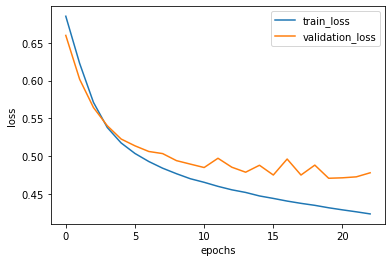

In [19]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'validation_loss'])
plt.show()

- one-hot 인코딩에 비해 word embedding이 훨씬 빠르게 계산을 완료함 (1 epochs 당 7s -> 3s) 
- 모델의 성능은 거의 비슷 (accuracy : 0.7880 -> 0.7766) 

In [20]:
## 모델의 성능 보기 
## test_input에도 train_input과 마찬가지로 padding이 적용되어야 한다. 

test_seq = pad_sequences(test_input, maxlen = 100)
word_embedding_rnn_model = keras.models.load_model('best-embedding-rnn-model.h5')
word_embedding_rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 2s 2ms/step - loss: 0.4743 - accuracy: 0.7780


[0.4743195176124573, 0.7780399918556213]